# TimeGPT

> Unlock the power of accurate predictions and confidently navigate uncertainty. Reduce uncertainty and resource limitations. With TimeGPT, you can effortlessly access state-of-the-art models to make data-driven decisions. Whether you're a bank forecasting market trends or a startup predicting product demand, TimeGPT democratizes access to cutting-edge predictive insights, eliminating the need for a dedicated team of machine learning engineers.

## Introduction

Nixtla's TimeGPT is a generative pre-trained model trained to forecast time series data. The inputs to TimeGPT are time series data, and the model generates forecast outputs based on these. The input involves providing the historical data and potentially defining parameters such as the forecast horizon. TimeGPT can be used across a plethora of tasks including demand forecasting, anomaly detection, financial forecasting, and more. 

The TimeGPT model "reads" time series data much like the way humans read a sentence – from left to right. It looks at a chunk of past data, which we can think of as "tokens", and predicts what comes next. This prediction is based on patterns the model identifies in past data, much like how a human would predict the end of a sentence based on the beginning.

The TimeGPT API provides an interface to this powerful model, allowing users to leverage its forecasting capabilities to predict future events based on past data. With this API, users can not only forecast future events but also delve into various time series-related tasks, such as what-if scenarios, anomaly detection, and more.

![figure](./img/timegpt-arch.png)

In [ ]:
#| default_exp timegpt

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import logging
import inspect
import json
import requests
from typing import Dict, List, Optional, Union

import pandas as pd

logger = logging.getLogger()

In [ ]:
#| hide
import os
from itertools import product

from dotenv import load_dotenv
from fastcore.test import test_eq, test_fail
from nbdev.showdoc import show_doc


load_dotenv()
logging.getLogger('statsforecast').setLevel(logging.ERROR)

In [ ]:
#| exporti
class TimeGPT:
    """
    A class used to interact with the TimeGPT API.
    """

    def __init__(self, token: str):
        """
        Constructs all the necessary attributes for the TimeGPT object.

        Parameters
        ----------
        token : str
            The authorization token to interact with the TimeGPT API.
        """
        self.token = token
        self.api_url = 'https://dashboard.nixtla.io/api'
        self.weights_x: pd.DataFrame = None

    @property
    def request_headers(self):
        headers = {
            "accept": "application/json",
            "content-type": "application/json",
            "authorization": f"Bearer {self.token}"
        }
        return headers
        
    def _parse_response(self, response) -> Dict:
        """Parses responde."""
        response.raise_for_status()
        try:
            resp = response.json()
        except Exception as e:
            raise Exception(response)
        return resp
    
    def validate_token(self) -> bool:
        """Returns True if your token is valid."""
        response = requests.post(
            f'{self.api_url}/validate_token_front',
            headers=self.request_headers,
        )
        valid = True
        try:
            response = self._parse_response(response)
        except:
            valid = False
        return valid

    def _input_size(self, freq: str):
        response_input_size = requests.post(
            f'{self.api_url}/timegpt_input_size',
            json={'freq': freq}, 
            headers=self.request_headers,
        )
        response_input_size = self._parse_response(response_input_size)
        return response_input_size['data']

    def _validate_inputs(
            self,
            df: pd.DataFrame,
            X_df: pd.DataFrame,
            id_col: str,
            time_col: str,
            target_col: str,
        ):
        renamer = {
            id_col: 'unique_id',
            time_col: 'ds',
            target_col: 'y'
        }
        df = df.rename(columns=renamer)
        if df.dtypes.ds != 'object':
            df['ds'] = df['ds'].astype(str)
        drop_uid = False
        if 'unique_id' not in df.columns:
            # Insert unique_id column
            df = df.assign(unique_id='ts_0')
            drop_uid = True
        if X_df is not None:
            X_df = X_df.rename(columns=renamer)
            if 'unique_id' not in df.columns:
                X_df = X_df.assign(unique_id='ts_0')
            if X_df.dtypes.ds != 'object':
                X_df['ds'] = X_df['ds'].astype(str)
        return df, X_df, drop_uid

    def _validate_outputs(
            self,
            fcst_df: pd.DataFrame,
            id_col: str,
            time_col: str,
            target_col: str,
            drop_uid: bool,
        ):
        renamer = {
            'unique_id': id_col,
            'ds': time_col,
            'target_col': target_col,
        }
        if drop_uid:
            fcst_df = fcst_df.drop(columns='unique_id')
        fcst_df = fcst_df.rename(columns=renamer)
        return fcst_df

    def _infer_freq(self, df: pd.DataFrame):
        unique_id = df.iloc[0]['unique_id']
        df_id = df.query('unique_id == @unique_id')
        freq = pd.infer_freq(df_id['ds'])
        if freq is None:
            raise Exception('"Could not infer frequency of ds column. This could be due to \
                inconsistent intervals. Please check your data for missing, duplicated or irregular timestamps."')
        return freq

    def _preprocess_inputs(
            self, 
            df: pd.DataFrame, 
            h: int,
            freq: str,
            X_df: Optional[pd.DataFrame] = None,
        ):
        input_size = self._input_size(freq)
        y_cols = ['unique_id', 'ds', 'y']
        y = df[y_cols].groupby('unique_id').tail(input_size + h)
        to_dict_args = {'orient': 'split'}
        if 'index' in inspect.signature(pd.DataFrame.to_dict).parameters:
            to_dict_args['index'] = False
        y = y.to_dict(**to_dict_args)
        x_cols = df.drop(columns=y_cols).columns.to_list()
        if len(x_cols) == 0 or X_df is None:
            x = None
        else:
            if not all(col in X_df.columns for col in x_cols):
                raise Exception(
                    'You must pass the future values of these '
                    f'exogenous variables {",".join(x_cols)}'
                )
            x = pd.concat([df[['unique_id', 'ds'] + x_cols].groupby('unique_id').tail(input_size + h), X_df])
            x = x.sort_values(['unique_id', 'ds'])
            x = x.to_dict(**to_dict_args)
        return y, x, x_cols

    def _multi_series(
            self,
            df: pd.DataFrame,
            h: int,
            freq: str,
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[int]] = None,
            finetune_steps: int = 0,
            clean_ex_first: bool = True,
        ):
        if freq is None:
            freq = self._infer_freq(df)
        y, x, x_cols = self._preprocess_inputs(df=df, h=h, freq=freq, X_df=X_df)
        payload = dict(
            y=y,
            x=x,
            fh=h,
            freq=freq,
            level=level,
            finetune_steps=finetune_steps,
            clean_ex_first=clean_ex_first,
        )
        response_timegpt = requests.post(
            f'{self.api_url}/timegpt_multi_series',
            json=payload, 
            headers=self.request_headers,
        )
        response_timegpt = self._parse_response(response_timegpt)
        if 'weights_x' in response_timegpt['data']:
            self.weights_x = pd.DataFrame({
                'features': x_cols,
                'weights': response_timegpt['data']['weights_x'],
            })
        return pd.DataFrame(**response_timegpt['data']['forecast'])

    def forecast(
            self,
            df: pd.DataFrame,
            h: int,
            freq: Optional[str] = None,    
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[Union[int, float]]] = None,
            finetune_steps: int = 0,
            clean_ex_first: bool = True,
        ):
        """Forecast your time series using TimeGPT.

        Parameters
        ----------
        df : pandas.DataFrame
            The DataFrame on which the function will operate. Expected to contain at least the following columns:
            - time_col:
                Column name in `df` that contains the time indices of the time series. This is typically a datetime
                column with regular intervals, e.g., hourly, daily, monthly data points.
            - target_col:
                Column name in `df` that contains the target variable of the time series, i.e., the variable we 
                wish to predict or analyze.
            Additionally, you can pass multiple time series (stacked in the dataframe) considering an additional column:
            - id_col:
                Column name in `df` that identifies unique time series. Each unique value in this column
                corresponds to a unique time series.
        h : int
            Forecast horizon.
        freq : str
            Frequency of the data. By default, the freq will be inferred automatically.
            See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        id_col : str (default='unique_id')
            Column that identifies each serie.
        time_col : str (default='ds')
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str (default='y')
            Column that contains the target.
        X_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        level : List[float], optional (default=None)
            Confidence levels between 0 and 100 for prediction intervals.
        finetune_steps : int (default=0)
            Number of steps used to finetune TimeGPT in the
            new data.
        clean_ex_first : bool (default=True)
            Clean exogenous signal before making forecasts
            using TimeGPT.
        
        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with TimeGPT forecasts for point predictions and probabilistic
            predictions (if level is not None).
        """
        if not self.validate_token():
            raise Exception(
                'Token not valid, please go to https://dashboard.nixtla.io/ to get yours'
            )
            
        df, X_df, drop_uid = self._validate_inputs(
            df=df,
            X_df=X_df,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
        )
        fcst_df = self._multi_series(
            df=df, 
            h=h,
            freq=freq,
            X_df=X_df,
            level=level, 
            finetune_steps=finetune_steps,
            clean_ex_first=clean_ex_first,
        )
        fcst_df = self._validate_outputs(
            fcst_df=fcst_df,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            drop_uid=drop_uid,
        )
        return fcst_df

## Usage

In [ ]:
show_doc(TimeGPT.__init__, title_level=3, name='TimeGPT')

/Users/fedex/miniconda3/envs/nixtlats/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


---

### TimeGPT

>      TimeGPT (token:str)

Constructs all the necessary attributes for the TimeGPT object.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| token | str | The authorization token to interact with the TimeGPT API. |

You can instantiate the `TimeGPT` class providing your credentials.

In [ ]:
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

You can test the validate of your token calling the `validate_token` method:

In [ ]:
show_doc(TimeGPT.validate_token)

---

### TimeGPT.validate_token

>      TimeGPT.validate_token ()

Returns True if your token is valid.

In [ ]:
timegpt.validate_token()

True

In [ ]:
#| hide
test_eq(
    TimeGPT(token='transphobic').validate_token(),
    False
)

In [ ]:
#| hide
test_fail(
    lambda x: TimeGPT(token='transphobic').forecast(df=None, h=None)
)

In [ ]:
#| hide
# test input_size
test_eq(
    timegpt._input_size('D'),
    28,
)

In [ ]:
show_doc(TimeGPT.forecast, title_level=4)

---

#### TimeGPT.forecast

>      TimeGPT.forecast (df:pandas.core.frame.DataFrame, h:int,
>                        freq:Optional[str]=None, id_col:str='unique_id',
>                        time_col:str='ds', target_col:str='y',
>                        X_df:Optional[pandas.core.frame.DataFrame]=None,
>                        level:Optional[List[Union[int,float]]]=None,
>                        finetune_steps:int=0, clean_ex_first:bool=True)

Forecast your time series using TimeGPT.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | DataFrame |  | The DataFrame on which the function will operate. Expected to contain at least the following columns:<br>- time_col:<br>    Column name in `df` that contains the time indices of the time series. This is typically a datetime<br>    column with regular intervals, e.g., hourly, daily, monthly data points.<br>- target_col:<br>    Column name in `df` that contains the target variable of the time series, i.e., the variable we <br>    wish to predict or analyze.<br>Additionally, you can pass multiple time series (stacked in the dataframe) considering an additional column:<br>- id_col:<br>    Column name in `df` that identifies unique time series. Each unique value in this column<br>    corresponds to a unique time series. |
| h | int |  | Forecast horizon. |
| freq | Optional | None | Frequency of the data. By default, the freq will be inferred automatically.<br>See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). |
| id_col | str | unique_id | Column that identifies each serie. |
| time_col | str | ds | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str | y | Column that contains the target. |
| X_df | Optional | None | DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. |
| level | Optional | None | Confidence levels between 0 and 100 for prediction intervals. |
| finetune_steps | int | 0 | Number of steps used to finetune TimeGPT in the<br>new data. |
| clean_ex_first | bool | True | Clean exogenous signal before making forecasts<br>using TimeGPT. |
| **Returns** | **pandas.DataFrame** |  | **DataFrame with TimeGPT forecasts for point predictions and probabilistic<br>predictions (if level is not None).** |

Now you can start to make forecasts! Let's import an example:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


Let's plot this series

<Axes: xlabel='timestamp'>

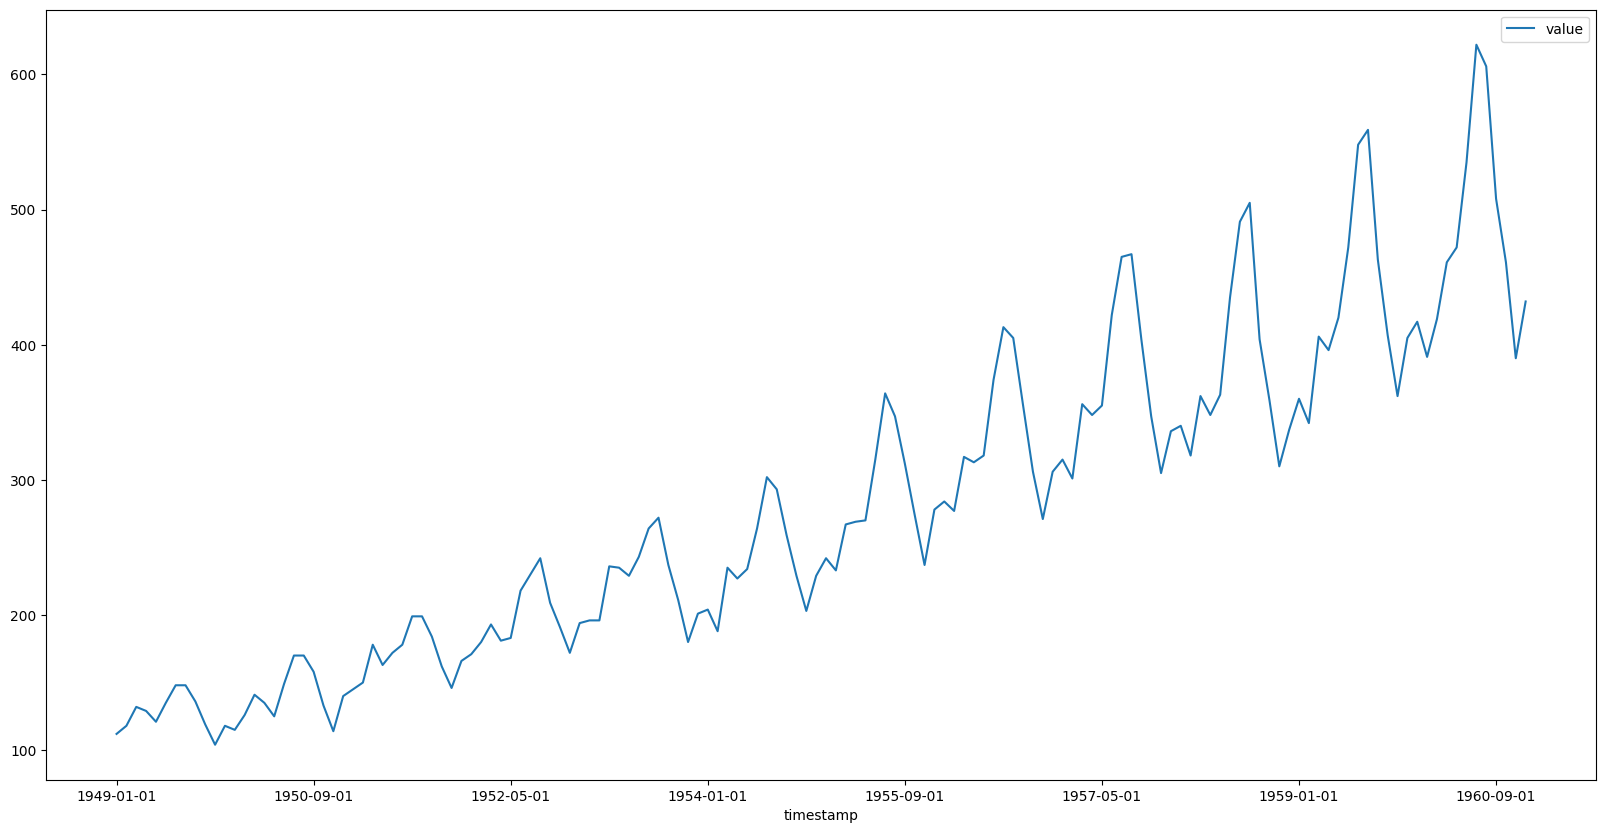

In [ ]:
df.set_index('timestamp').plot(figsize=(20, 10))

Now we can forecast this dataset. We observe that this dataset has monthly frequency. We have to pass the right pandas frequency to `TimeGPT` to have the right forecasts. In this case 'MS'. Let's forecast the next 12 observations. In this case we also have to define:

- `time_col`: Column that identifies the datestamp column.
- `target_col`: The variable that we want to forecast.

In [ ]:
timegpt_fcst_df = timegpt.forecast(df=df, h=12, time_col='timestamp', target_col='value')
timegpt_fcst_df.head()

,timestamp,TimeGPT
0,1961-01-01T00:00:00,437.837952
1,1961-02-01T00:00:00,426.062744
2,1961-03-01T00:00:00,463.116547
3,1961-04-01T00:00:00,478.244507
4,1961-05-01T00:00:00,505.646484


<Axes: xlabel='timestamp'>

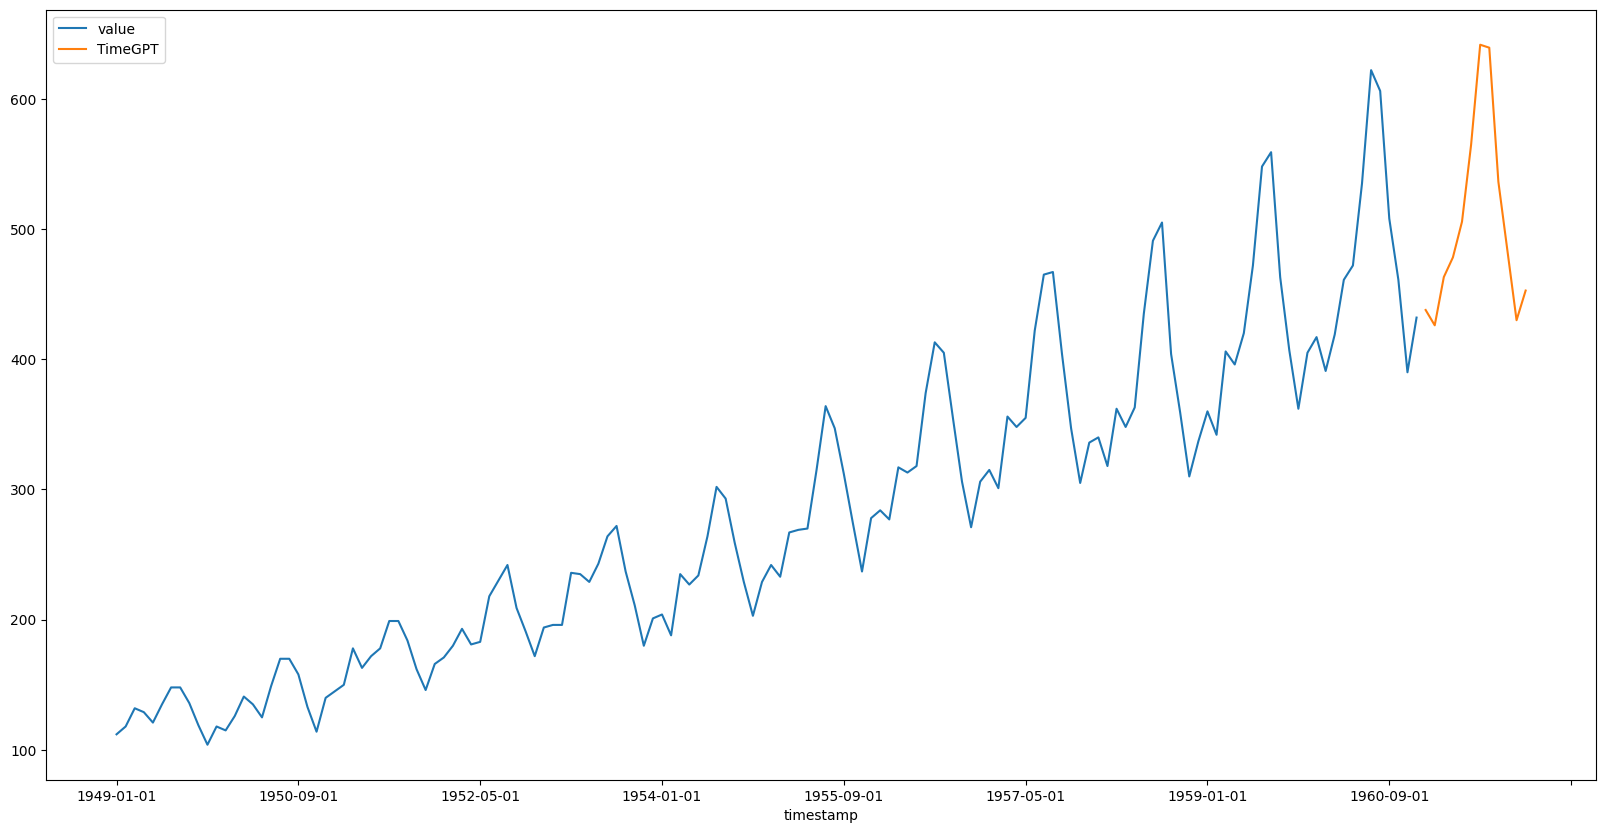

In [ ]:
pd.concat([df, timegpt_fcst_df]).set_index('timestamp').plot(figsize=(20, 10))

You can also produce a larger forecast horizon:

In [ ]:
timegpt_fcst_df = timegpt.forecast(df=df, h=36, time_col='timestamp', target_col='value')
timegpt_fcst_df.head()

,timestamp,TimeGPT
0,1961-01-01T00:00:00,437.837952
1,1961-02-01T00:00:00,426.062744
2,1961-03-01T00:00:00,463.116547
3,1961-04-01T00:00:00,478.244507
4,1961-05-01T00:00:00,505.646484


<Axes: xlabel='timestamp'>

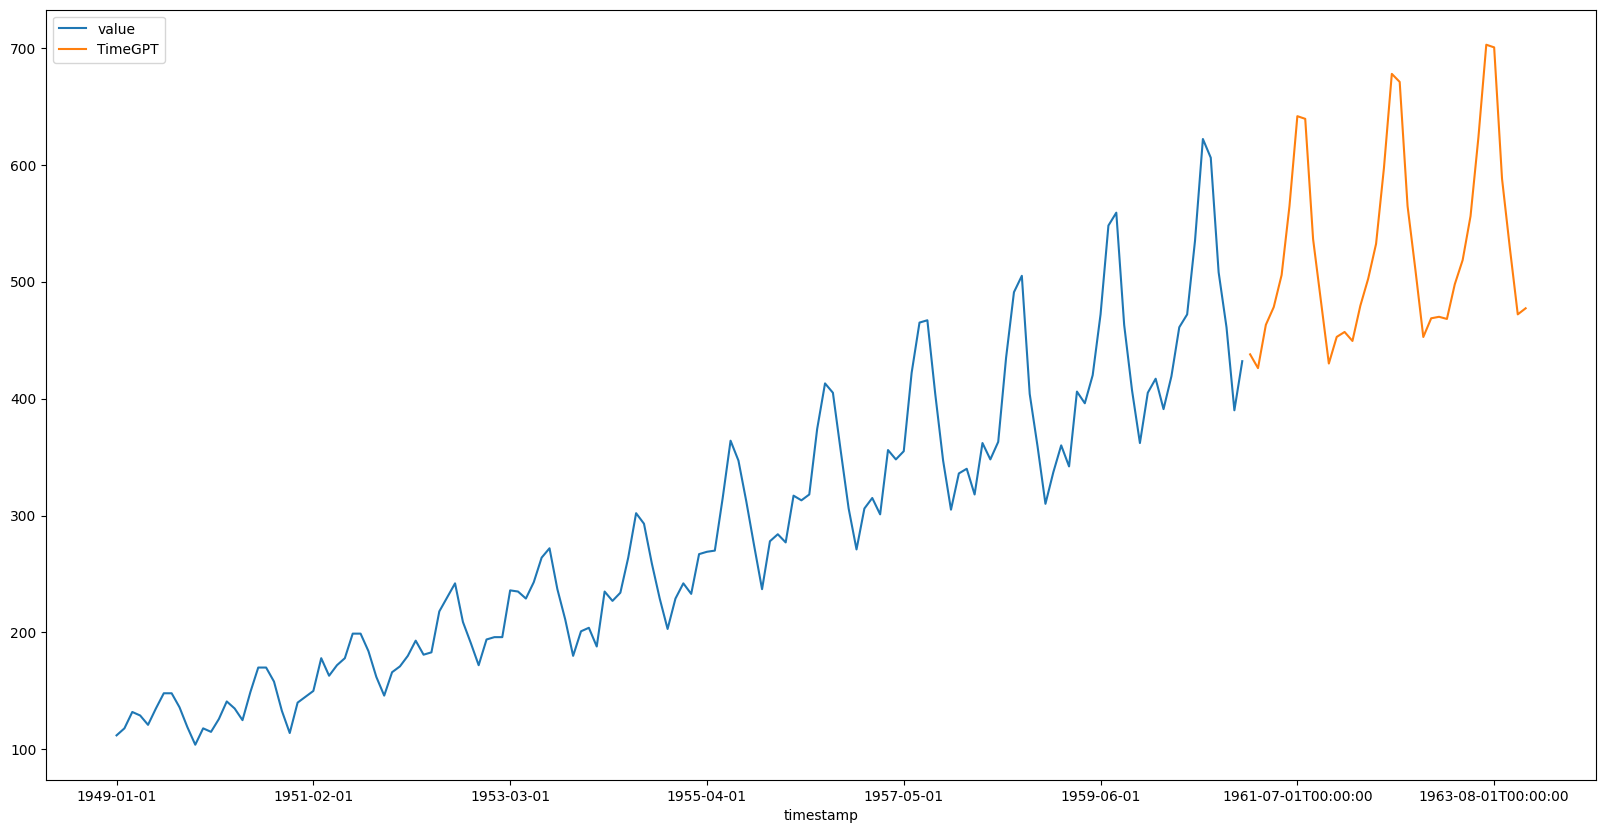

In [ ]:
pd.concat([df, timegpt_fcst_df]).set_index('timestamp').plot(figsize=(20, 10))

### Prediction Intervals

Prediction intervals provide a measure of the uncertainty in the forecasted values. In time series forecasting, a prediction interval gives an estimated range within which a future observation will fall, based on the level of confidence or uncertainty you set. This level of uncertainty is crucial for making informed decisions, risk assessments, and planning.

For instance, a 95% prediction interval means that 95 out of 100 times, the actual future value will fall within the estimated range. Therefore, a wider interval indicates greater uncertainty about the forecast, while a narrower interval suggests higher confidence.

When using TimeGPT for time series forecasting, you have the option to set the level of prediction intervals according to your requirements. TimeGPT uses conformal prediction to calibrate the intervals.

Here's how you could do it:

In [ ]:
timegpt_fcst_pred_int_df = timegpt.forecast(
    df=df, h=12, level=[80, 90], 
    time_col='timestamp', target_col='value',
)
timegpt_fcst_pred_int_df.head()

,timestamp,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1961-01-01T00:00:00,437.837952,435.600806,435.849377,439.826526,440.075098
1,1961-02-01T00:00:00,426.062744,415.042908,416.267334,435.858154,437.082581
2,1961-03-01T00:00:00,463.116547,441.402069,443.814789,482.418304,484.831024
3,1961-04-01T00:00:00,478.244507,459.120331,461.245239,495.243774,497.368683
4,1961-05-01T00:00:00,505.646484,497.399377,498.315723,512.977246,513.893591


In [ ]:
#| hide
test_level = [80, 90.5]
cols_fcst_df = timegpt.forecast(
    df=df, h=12, level=[80, 90.5], 
    time_col='timestamp', target_col='value',
).columns
assert all(f'TimeGPT-{pos}-{lv}' for pos, lv in product(test_level, ['lo', 'hi']) )

In [ ]:
import matplotlib.pyplot as plt

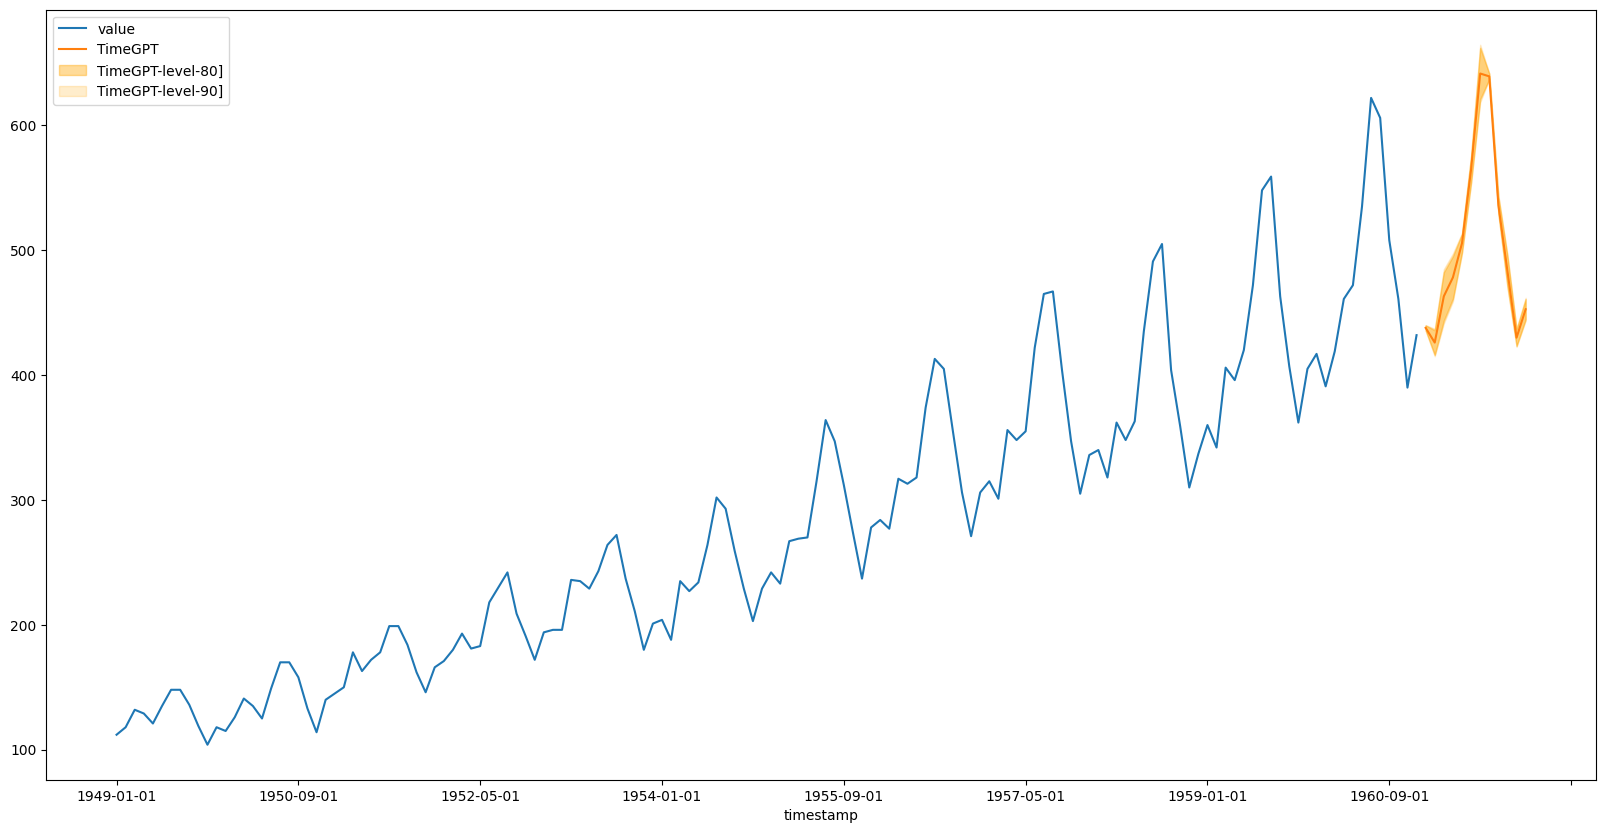

In [ ]:
history_with_fcst_df = pd.concat([df, timegpt_fcst_pred_int_df])
ax = history_with_fcst_df[['timestamp', 'value', 'TimeGPT']].set_index('timestamp').plot(figsize=(20, 10))
for level, alpha in zip([80, 90], [0.4, 0.2]):
    plt.fill_between(
        history_with_fcst_df['timestamp'], 
        history_with_fcst_df[f'TimeGPT-lo-{level}'], 
        history_with_fcst_df[f'TimeGPT-hi-{level}'], 
        color='orange', 
        alpha=alpha,
        label=f'TimeGPT-level-{level}]'
    )
plt.legend()
plt.show()

It's essential to note that the choice of prediction interval level depends on your specific use case. For high-stakes predictions, you might want a wider interval to account for more uncertainty. For less critical forecasts, a narrower interval might be acceptable.

### Finetuning

Fine-tuning is a process of further training a pre-existing model (like TimeGPT) on a specific task or dataset. This allows you to leverage the general language understanding capabilities of the pre-trained model and adapt it to your specific use case. 

In TimeGPT, you can use the `finetune_steps` argument to specify the number of additional training steps the model should undergo on your time series data. This helps in refining the model's understanding and prediction of your data patterns. 

Here's an example of how to fine-tune TimeGPT:

In [ ]:
timegpt_fcst_finetune_df = timegpt.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='value',
)

<Axes: xlabel='timestamp'>

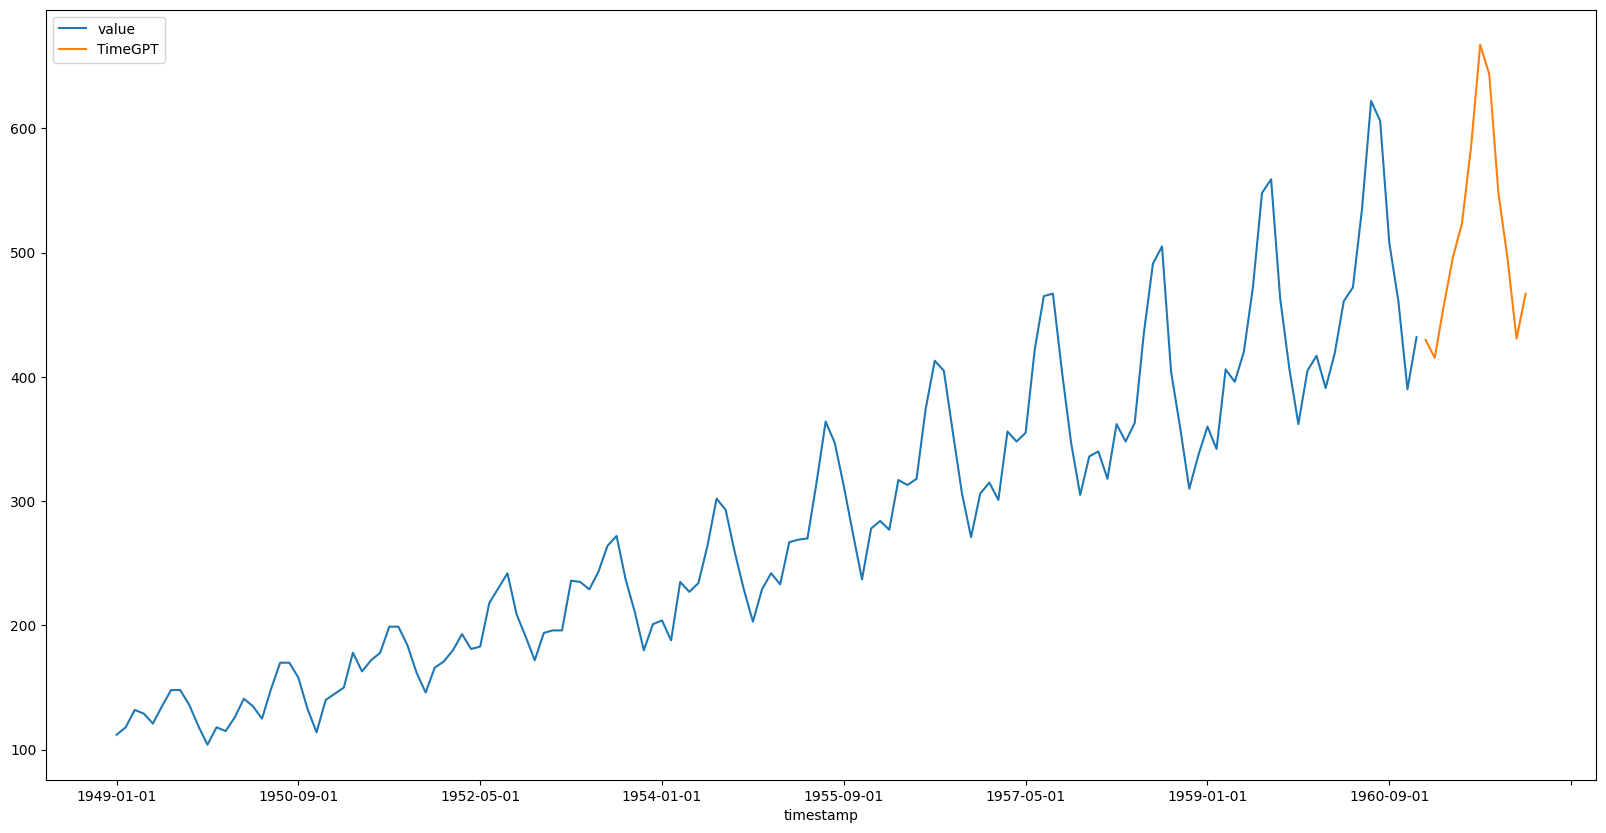

In [ ]:
pd.concat([df, timegpt_fcst_finetune_df]).set_index('timestamp').plot(figsize=(20, 10))

In this code, `finetune_steps: 10` means the model will go through 10 iterations of training on your time series data.

Keep in mind that fine-tuning can be a bit of trial and error. You might need to adjust the number of `finetune_steps` based on your specific needs and the complexity of your data. It's recommended to monitor the model's performance during fine-tuning and adjust as needed. Be aware that more `finetune_steps` may lead to longer training times and could potentially lead to overfitting if not managed properly. 

Remember, fine-tuning is a powerful feature, but it should be used thoughtfully and carefully.

### Multiple Series

TimeGPT provides a robust solution for multi-series forecasting, which involves analyzing multiple data series concurrently, rather than a single one. The tool can be fine-tuned using a broad collection of series, enabling you to tailor the model to suit your specific needs or tasks.

The following dataset contains prices of different electricity markets. Let see how can we forecast them.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df.head()

,unique_id,ds,y
0,BE,2016-12-01 00:00:00,72.00
1,BE,2016-12-01 01:00:00,65.80
2,BE,2016-12-01 02:00:00,59.99
3,BE,2016-12-01 03:00:00,50.69
4,BE,2016-12-01 04:00:00,52.58


Let's plot this series using [`StatsForecast`](https://github.com/Nixtla/statsforecast):

In [ ]:
from statsforecast import StatsForecast as sf

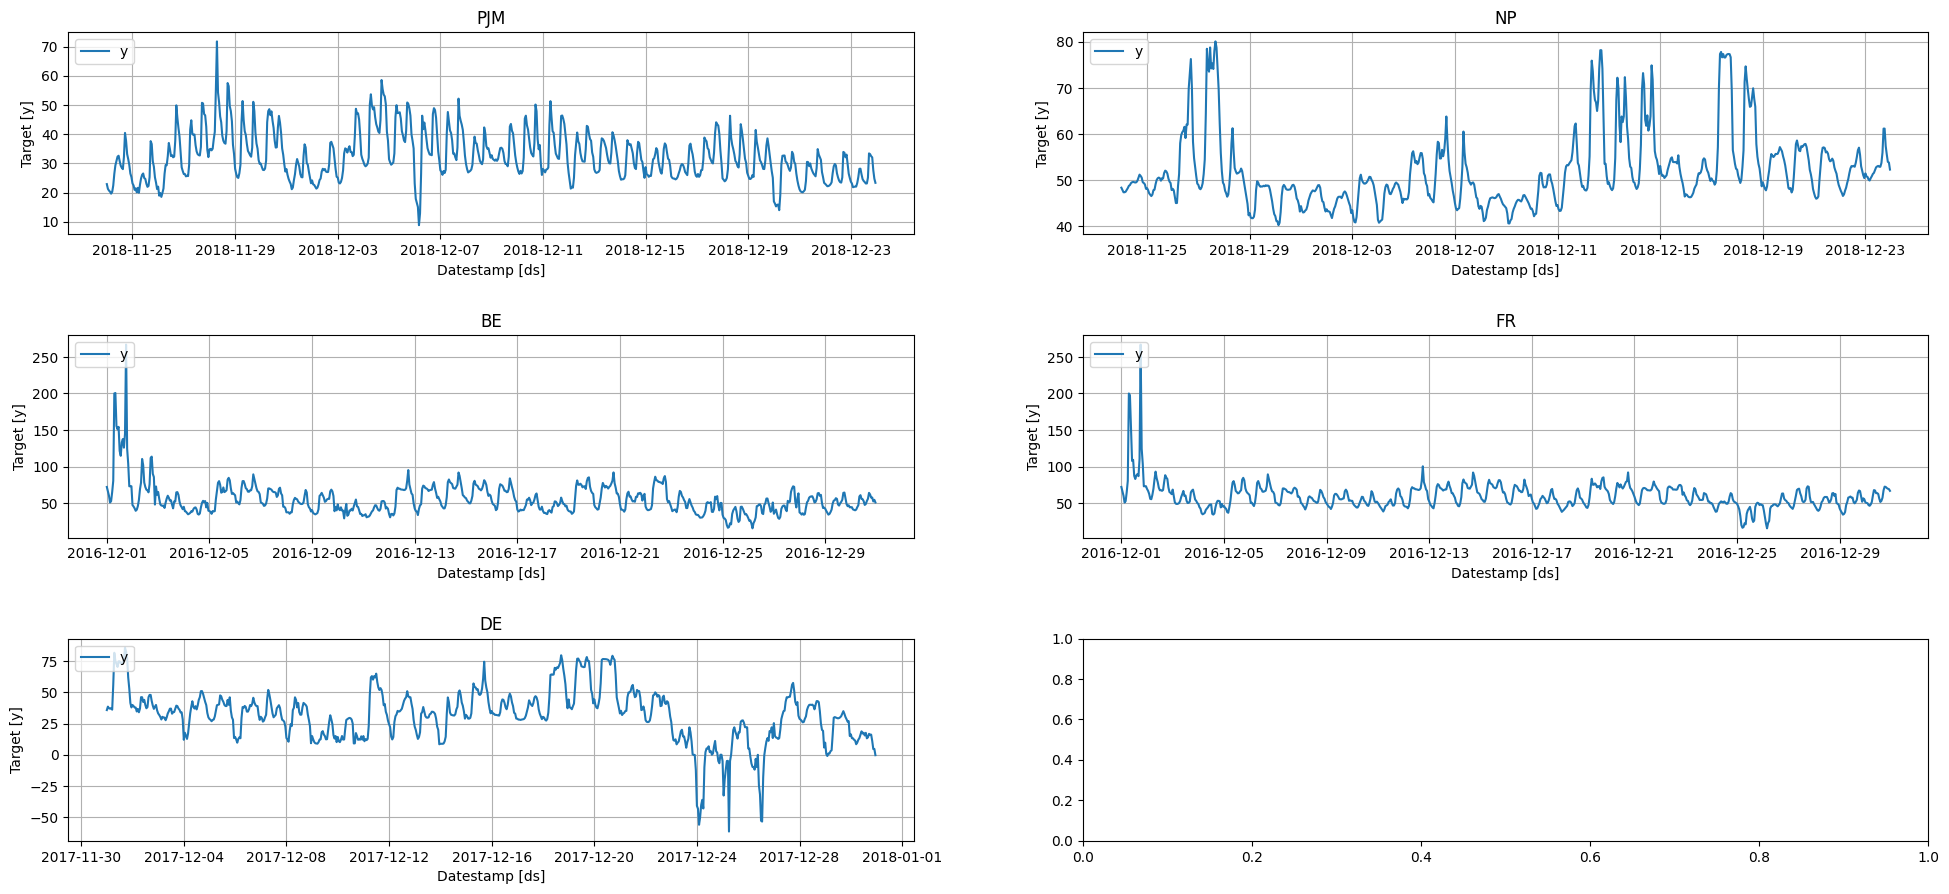

In [ ]:
sf.plot(df, engine='matplotlib')

We just have to pass the dataframe to create forecasts for all the time series at once.

In [ ]:
timegpt_fcst_multiseries_df = timegpt.forecast(df=df, h=24, level=[80, 90])
timegpt_fcst_multiseries_df.head()

,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,BE,2016-12-31T00:00:00,46.151176,41.403190,41.930744,50.371609,50.899163
1,BE,2016-12-31T01:00:00,42.426598,34.729459,35.584696,49.268499,50.123736
2,BE,2016-12-31T02:00:00,40.242889,34.288178,34.949813,45.535966,46.197601
3,BE,2016-12-31T03:00:00,38.265339,32.007584,32.702890,43.827788,44.523094
4,BE,2016-12-31T04:00:00,36.618797,28.403703,29.316491,43.921103,44.833891


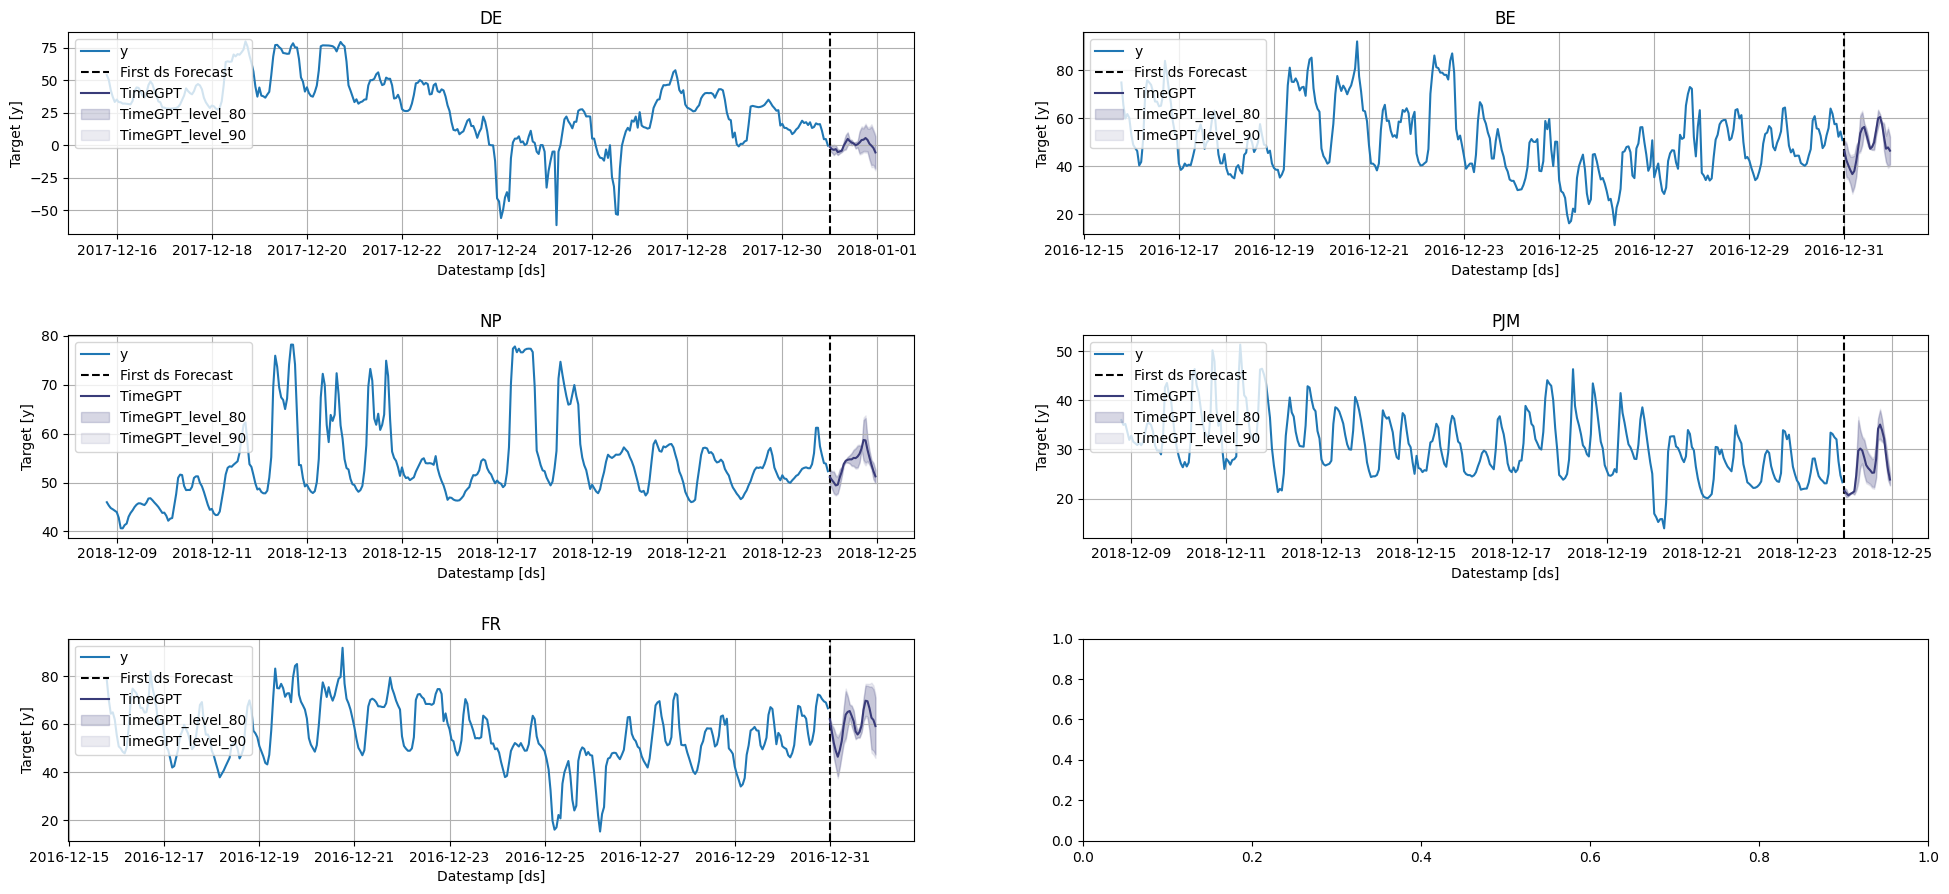

In [ ]:
sf.plot(df, timegpt_fcst_multiseries_df, max_insample_length=365, level=[80, 90], engine='matplotlib')

### Exogenous variables

Exogenous variables or external factors are crucial in time series forecasting as they provide additional information that might influence the prediction. These variables could include holiday markers, marketing spending, weather data, or any other external data that correlate with the time series data you are forecasting.

For example, if you're forecasting ice cream sales, temperature data could serve as a useful exogenous variable. On hotter days, ice cream sales may increase.

To incorporate exogenous variables in TimeGPT, you'll need to pair each point in your time series data with the corresponding external data.

Let's see an example.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-01 00:00:00,72.00,61507.0,71066.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,BE,2016-12-01 01:00:00,65.80,59528.0,67311.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,BE,2016-12-01 02:00:00,59.99,58812.0,67470.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,BE,2016-12-01 03:00:00,50.69,57676.0,64529.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,BE,2016-12-01 04:00:00,52.58,56804.0,62773.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


To produce forecasts we have to add the future values of the exogenous variables. Let's read this dataset. In this case we want to predict 24 steps ahead, therefore each unique id will have 24 observations.

In [ ]:
future_ex_vars_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,64108.0,70318.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,62492.0,67898.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,61571.0,68379.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,60381.0,64972.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,60298.0,62900.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's call the `forecast` method, adding this information:

In [ ]:
timegpt_fcst_ex_vars_df = timegpt.forecast(df=df, X_df=future_ex_vars_df, h=24, level=[80, 90])
timegpt_fcst_ex_vars_df.head()

,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,BE,2016-12-31T00:00:00,39.264566,34.516580,35.044134,43.484998,44.012552
1,BE,2016-12-31T01:00:00,36.569441,28.872302,29.727540,43.411342,44.266580
2,BE,2016-12-31T02:00:00,35.609012,29.654300,30.315935,40.902089,41.563723
3,BE,2016-12-31T03:00:00,33.714503,27.456748,28.152054,39.276952,39.972259
4,BE,2016-12-31T04:00:00,32.577741,24.362647,25.275436,39.880047,40.792836


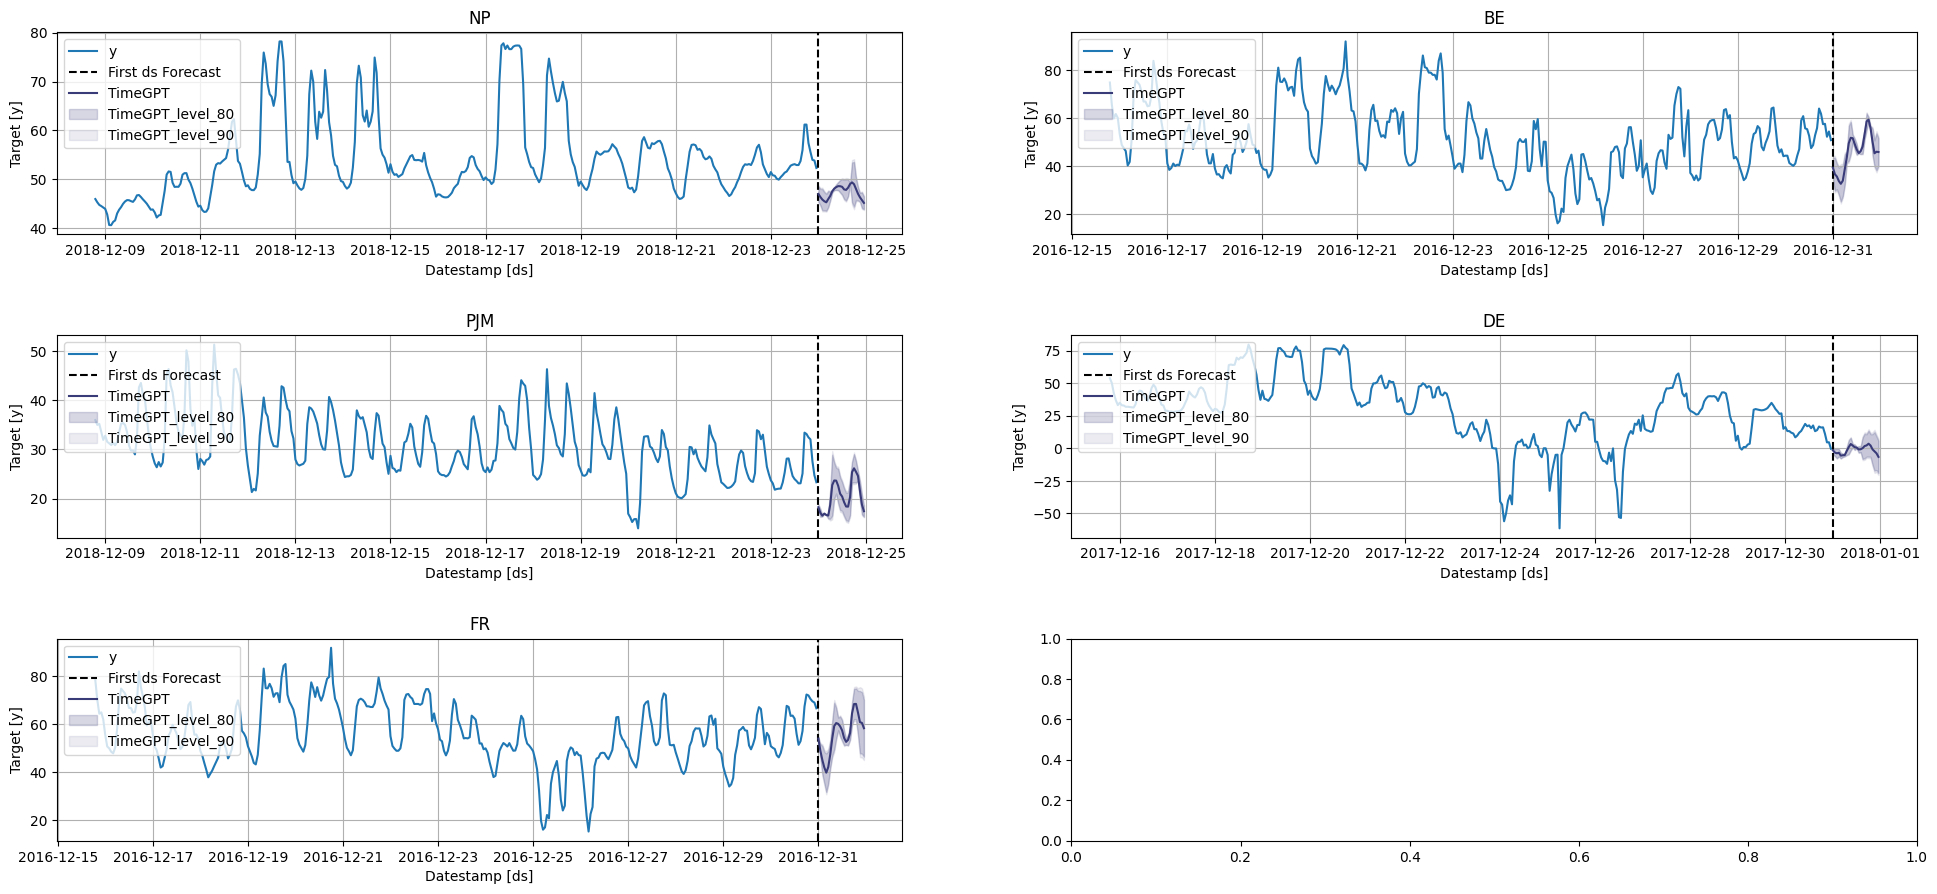

In [ ]:
sf.plot(df[['unique_id', 'ds', 'y']], timegpt_fcst_ex_vars_df, max_insample_length=365, level=[80, 90], engine='matplotlib')

We also can get the importance of the features.

<Axes: ylabel='features'>

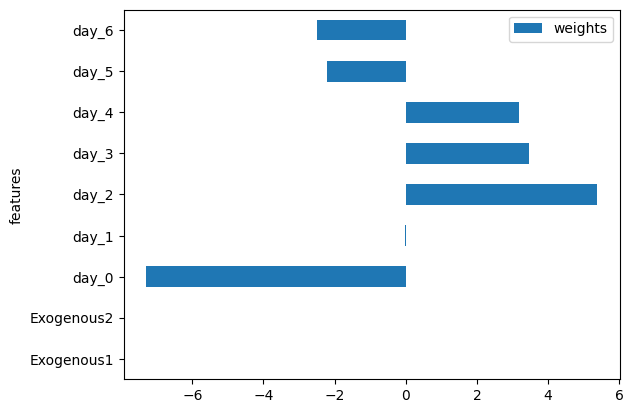

In [ ]:
timegpt.weights_x.plot.barh(x='features', y='weights')

### Forecasting Time Series with Irregular Timestamps

When working with time series data, the frequency of the timestamps is a crucial factor that can significantly impact the forecasting results. Regular frequencies like daily, weekly, or monthly are straightforward to handle. However, irregular frequencies like business days, which exclude weekends, can be challenging for time series forecasting methods.

Our forecast method is equipped to handle this kind of irregular time series data, as long as you specify the frequency of the series. For example, in the case of business days, the frequency should be passed as 'B'. Without this, the method might fail to automatically detect the frequency, especially when the timestamps are irregular.


The first step is to fetch your time series data. The data must include timestamps and the associated values. For instance, you might be working with stock prices, and your data could look something like the following. In this example we use [OpenBB](https://docs.openbb.co/sdk).

In [ ]:
#| hide
import sys
import io

backup = sys.stdin
sys.stdin = io.StringIO('Default input') 

In [ ]:
from openbb_terminal.sdk import openbb

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

In [ ]:
#| hide
sys.stdin = backup

In [ ]:
pltr_df = openbb.stocks.load('PLTR', start_date='2020-09-30').reset_index()

Loading Daily data for PLTR with starting period 2020-09-30.

In [ ]:
pltr_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400,0.0,0.0
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600,0.0,0.0
2,2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300,0.0,0.0
3,2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900,0.0,0.0
4,2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000,0.0,0.0


Let's see that this dataset has irregular timestamps. The dayofweek attribute from pandas' DatetimeIndex returns the day of the week with Monday=0, Sunday=6. So, checking if dayofweek > 4 is essentially checking if the date falls on a Saturday (5) or Sunday (6), which are typically non-business days (weekends).

In [ ]:
(pltr_df['date'].dt.dayofweek > 4).sum()

0

As we can see the timestamp is irregular. Let's inspect the `Close` series.

<Axes: xlabel='date'>

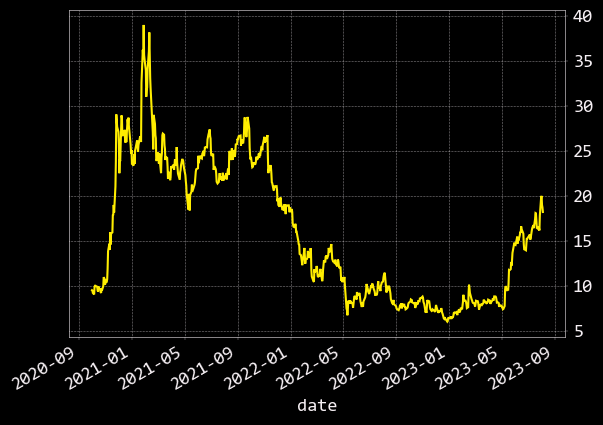

In [ ]:
pltr_df.set_index('date')['Close'].plot()

To forecast this data, you can use our `forecast` method. Importantly, remember to specify the frequency of the data using the `freq` argument. In this case, it would be 'B' for business days. We also need to define the `time_col` to select the index of the series (by default is `ds`), and the `target_col` to forecast our target variable, in this case we will forecast `Close`:

In [ ]:
#| hide
# fails to infer "B" frequency
test_fail(
    lambda x: timegpt.forecast(
        df=pltr_df, h=14,
        time_col='date', target_col='Close',
    ),
)

In [ ]:
fcst_pltr_df = timegpt.forecast(
    df=pltr_df, h=14, freq='B',
    time_col='date', target_col='Close',
)

In [ ]:
fcst_pltr_df.head()

,date,TimeGPT
0,2023-08-07T00:00:00,17.943554
1,2023-08-08T00:00:00,17.776838
2,2023-08-09T00:00:00,17.544336
3,2023-08-10T00:00:00,17.674099
4,2023-08-11T00:00:00,17.839178


Remember, for business days, the frequency is 'B'. For other frequencies, you can refer to the pandas offset aliases documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases.

By specifying the frequency, you're helping the forecast method better understand the pattern in your data, resulting in more accurate and reliable forecasts.

Let's plot the forecasts generated by `TimeGPT`.

<Axes: xlabel='date'>

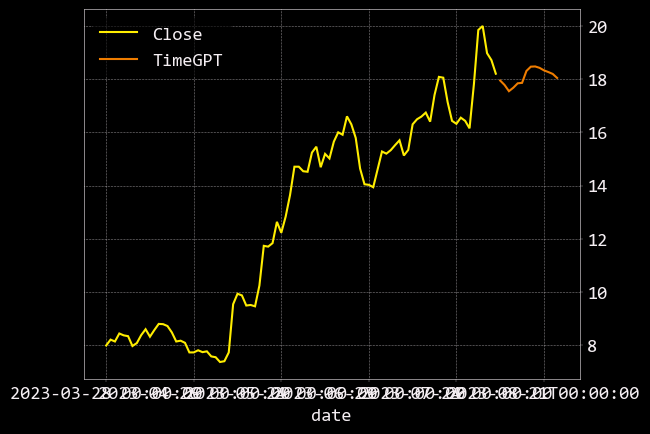

In [ ]:
pd.concat([
    pltr_df[['date', 'Close']].tail(90),
    fcst_pltr_df
]).set_index('date').plot()

If you want to forecast another just change the `target_col` parameter. Let's forecast `Volume` now:

<Axes: xlabel='date'>

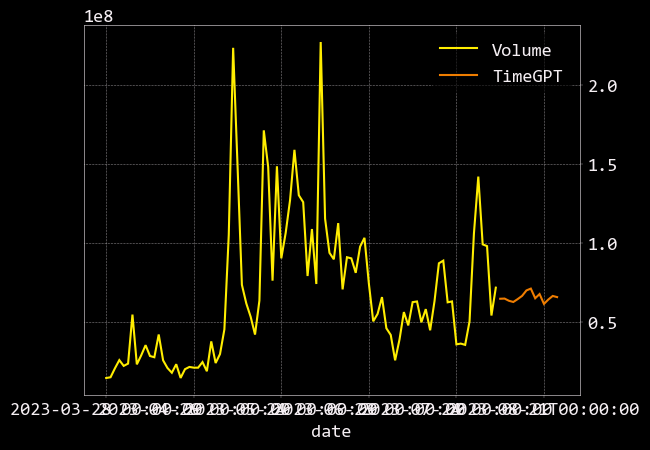

In [ ]:
fcst_pltr_df = timegpt.forecast(
    df=pltr_df, h=14, freq='B',
    time_col='date', target_col='Volume',
)
pd.concat([
    pltr_df[['date', 'Volume']].tail(90),
    fcst_pltr_df
]).set_index('date').plot()

But what if we want to predict all the time series at once? We can do that reshaping our dataframe. Currently, the dataframe is in wide format (each series is a column), but we need to have them in long format (stacked one each other). We can do it with: 

In [ ]:
pltr_long_df = pd.melt(
    pltr_df, 
    id_vars=['date'],
    var_name='series_id'
)

In [ ]:
pltr_long_df.head()

,date,series_id,value
0,2020-09-30,Open,10.00
1,2020-10-01,Open,9.69
2,2020-10-02,Open,9.06
3,2020-10-05,Open,9.43
4,2020-10-06,Open,9.04


Then we just simply call the `forecast` method specifying the `id_col` parameter.

In [ ]:
fcst_pltr_long_df = timegpt.forecast(
    df=pltr_long_df, h=14, freq='B',
    id_col='series_id', time_col='date', target_col='value',
)

In [ ]:
fcst_pltr_long_df.head()

,series_id,date,TimeGPT
0,Adj Close,2023-08-07T00:00:00,17.943554
1,Adj Close,2023-08-08T00:00:00,17.776838
2,Adj Close,2023-08-09T00:00:00,17.544336
3,Adj Close,2023-08-10T00:00:00,17.674099
4,Adj Close,2023-08-11T00:00:00,17.839178


Then we can forecast the `Open` series:

<Axes: xlabel='date'>

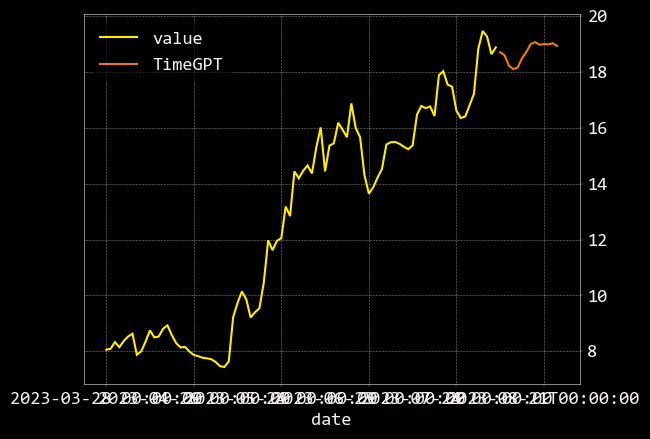

In [ ]:
pd.concat([
    pltr_long_df.query('series_id == "Open"').tail(90),
    fcst_pltr_long_df.query('series_id == "Open"')
]).set_index('date').plot()